In [1]:
from collections import defaultdict
import json
from tqdm import tqdm
import wptools
import re
from collections import defaultdict

In [2]:
def parse_occupations(text):
    """Extracts multiple occupations from complex formatted strings."""
    # Handle {{hlist|...}} and {{flatlist|...}}
    if '{{' in text:
        text = re.sub(r'\[\[([^\]]+)\]\]', r'\1', text)  # Simplify links
        text = re.sub(r'{{[^|]*\|', '', text)  # Remove the template up to the first '|'
        text = re.sub(r'}}', '', text)  # Remove closing braces
    # Handle <br> tags and strip unwanted characters
    text = re.sub(r'<br\s*/?>', '|', text)  # Replace <br> with |
    
    # Remove additional unwanted characters
    text = re.sub(r'\[\[|\]\]', '', text)  # Remove double brackets
    text = re.sub(r'\* ', '', text)  # Remove asterisks with spaces

    # Split by '|' and new lines as well as commas now
    occupations = re.split(r'\||\n|,', text)
    return [occupation.strip("*").strip().lower() for occupation in occupations if occupation.strip()]


def get_occupation_from_wikipedia(entity):
    """Use wptools to fetch and parse the occupation from Wikipedia without verbose output."""
    try:
        page = wptools.page(entity, silent=True).get_parse(show=False)
        infobox = page.data['infobox']
        if 'occupation' in infobox:
            return parse_occupations(infobox['occupation'])
        else:
            return ["Occupation not listed"]
    except Exception as e:
        return [f"Error retrieving page: {str(e)}"]

In [3]:
def process_entities(all_data, top_ten):
    """Process entities to create occupation groups and counts"""
    occupation_count = defaultdict(int)
    group_occupations = defaultdict(dict)  # {occupation: {entity: summary}}
    
    for entry in tqdm(all_data, desc="Processing entities"):
        entity = entry['topic'].strip()
        summary = entry['summary']
        
        # Get occupations from Wikipedia
        occupations = get_occupation_from_wikipedia(entity)
        
        # Filter valid occupations
        valid_occupations = [
            occ.lower() for occ in occupations
            if "error" not in occ.lower() 
            and "not listed" not in occ.lower()
        ]
        
        # Update counts and groups
        for occ in valid_occupations:
            if occ in top_ten:
                occupation_count[occ] += 1
                group_occupations[occ][entity] = summary
    
    return occupation_count, group_occupations

In [4]:
def load_data_from_jsonl(jsonl_files):
    data = []
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Each line is a complete JSON object
                entry = json.loads(line)
                data.append(entry)
    return data

# Assuming you have paths to your JSONL files
labled_path = 'data/labeled/'
jsonl_files = [labled_path+'ChatGPT.jsonl', labled_path+'InstructGPT.jsonl', labled_path+'PerplexityAI.jsonl']
all_data = load_data_from_jsonl(jsonl_files)
labeld_data = [{'topic': i['topic'],'summary':i['output']} for i in all_data]

In [5]:
import json
from pathlib import Path

def load_data_from_jsonl(jsonl_files):
    data = []
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Each line is a complete JSON object
                entry = json.loads(line)
                data.append(entry)
    return data

unlabeled_path = Path('data/unlabeled')
labeled_path = Path('data/labeled')
jsonl_files = list(unlabeled_path.glob('*.jsonl'))+list(labeled_path.glob('*.jsonl'))######
all_data = load_data_from_jsonl(jsonl_files)
unlabeld_data = [{'topic': i['topic'],'summary':i['output']} for i in all_data]


In [6]:
all_data = labeld_data +unlabeld_data

In [7]:
len(all_data)

7098

In [9]:
top_ten = ["actor", "actress", "singer", "producer", "musician", "director", "writer", "songwriter", "politician", "author"]
occupation_count, group_occupations = process_entities(all_data, top_ten)

Processing entities:   0%|          | 0/7098 [00:00<?, ?it/s]

Processing entities: 100%|██████████| 7098/7098 [40:19<00:00,  2.93it/s]


In [11]:
occupation_count

defaultdict(int,
            {'actor': 708,
             'actress': 540,
             'singer': 486,
             'author': 126,
             'writer': 174,
             'politician': 168,
             'songwriter': 330,
             'producer': 228,
             'musician': 192,
             'director': 60})

In [10]:
with open("output/top_ten/gen_summaries_all.json", "w") as f:
    json.dump(group_occupations, f, indent=2, ensure_ascii=False)

In [21]:
group_occupations.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

In [12]:
import os
import json
import re
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# # Initialize NLP tools
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
# custom_stop_words = {'also', 'known', 'later', 'born', 'became', 'lxi', 'lx', '``', '-lrb-', '-rrb-',"'s",'--'} 
# stop_words.update(custom_stop_words)
# punctuation = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

# def preprocess_text(text):
#     """Tokenize, lemmatize, and clean text"""
#     tokens = word_tokenize(text.lower())
#     cleaned = []
#     for token in tokens:
#         if token not in stop_words and token not in punctuation:
#             lemma = lemmatizer.lemmatize(token)
#             cleaned.append(lemma)
#     return cleaned

# def get_feature_probabilities(occupation_groups, top_n=50):
#     """Calculate P(f|occupation) for top features"""
#     feature_probs = defaultdict(dict)
#     pair_count = defaultdict(dict)
#     occ_count = defaultdict(int)
#     all_matrices = defaultdict(int)
    
#     for occupation, summaries in tqdm(occupation_groups.items(), desc="Processing occupations"):
#         # print(occupation)
#         # Collect all words across summaries
#         all_words = []
#         co_occurrence_counts = defaultdict(lambda: defaultdict(int))
#         feature_counts = defaultdict(int)

#         for summary in summaries.values():
#             all_words.extend(preprocess_text(summary))
            
#         word_counts = Counter(all_words)
#         top_features = [word for word, _ in word_counts.most_common(top_n)]

#         for word in top_features:
#             pair_count[occupation][word] = 0
#             for word2 in top_features:
#                 co_occurrence_counts[word][word2] = 0
        
#         for summary in summaries.values():
#             s = preprocess_text(summary)
#             occ_count[occupation] += 1
#             for word in top_features:
#                 # print(word)
#                 # print(s)
#                 if word in s:
#                     pair_count[occupation][word] += 1

#             features_in_summary = [word for word in s if word in top_features]
#             in_this_summary = set()
#             for i in range(len(features_in_summary)):
#                 for j in range(i + 1, len(features_in_summary)):
#                     if (features_in_summary[i],features_in_summary[j]) not in in_this_summary:
#                         in_this_summary.add((features_in_summary[i], features_in_summary[j]))
#                         feature_counts[features_in_summary[i]] += 1
#                         co_occurrence_counts[features_in_summary[i]][features_in_summary[j]] += 1      

#         matrix_size = len(top_features)
#         probability_matrix = np.zeros((matrix_size, matrix_size))
        
#         for i, f1 in enumerate(top_features):
#             total_co_occurrences = sum(co_occurrence_counts[f1].values())
#             for j, f2 in enumerate(top_features):
#                 # if f1 != f2 and total_co_occurrences > 0:
#                 if total_co_occurrences > 0:
#                     probability_matrix[i, j] = co_occurrence_counts[f1][f2] / total_co_occurrences  
        
#         all_matrices[occupation] = {'features': top_features, 'matrix': probability_matrix}

#         for word in top_features:
#             feature_probs[occupation][word] = pair_count[occupation][word] / occ_count[occupation]
    
#     return feature_probs, all_matrices


In [33]:
from utils import preprocess_text, get_feature_probabilities

[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
with open("output/top_ten/gen_summaries_all.json", "r") as f:
    group_occupations = json.load(f)

In [35]:
group_occupations.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

In [36]:
import os
import json
from collections import defaultdict
import numpy as np

# Save feature probabilities (already JSON-serializable)
def save_feature_probs(feature_probs, output_path):
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(feature_probs, f, indent=2, ensure_ascii=False)

# Save all_matrices by converting NumPy arrays to lists
def save_all_matrices(all_matrices, output_path):
    all_matrices_serializable = {}
    for occ, mat_dict in all_matrices.items():
        all_matrices_serializable[occ] = {
            "features": mat_dict["features"],
            "matrix": mat_dict["matrix"].tolist()  # convert NumPy array to list
        }
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(all_matrices_serializable, f, indent=2, ensure_ascii=False)

In [37]:
feature_probs, all_matrices = get_feature_probabilities(group_occupations)
save_feature_probs(feature_probs, "output/top_ten/feature_probabilities_gen.json")
save_all_matrices(all_matrices, "output/top_ten/all_matrices_gen.json")

Processing occupations: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


In [38]:
# # both f_1|occ and matrices
# feature_probs, all_matrices = get_feature_probabilities(group_occupations)
# with open("output/top_ten/feature_probabilities_gen.json", "w") as f:
#     json.dump(feature_probs, f, indent=2, ensure_ascii=False)

In [31]:
feature_probs.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

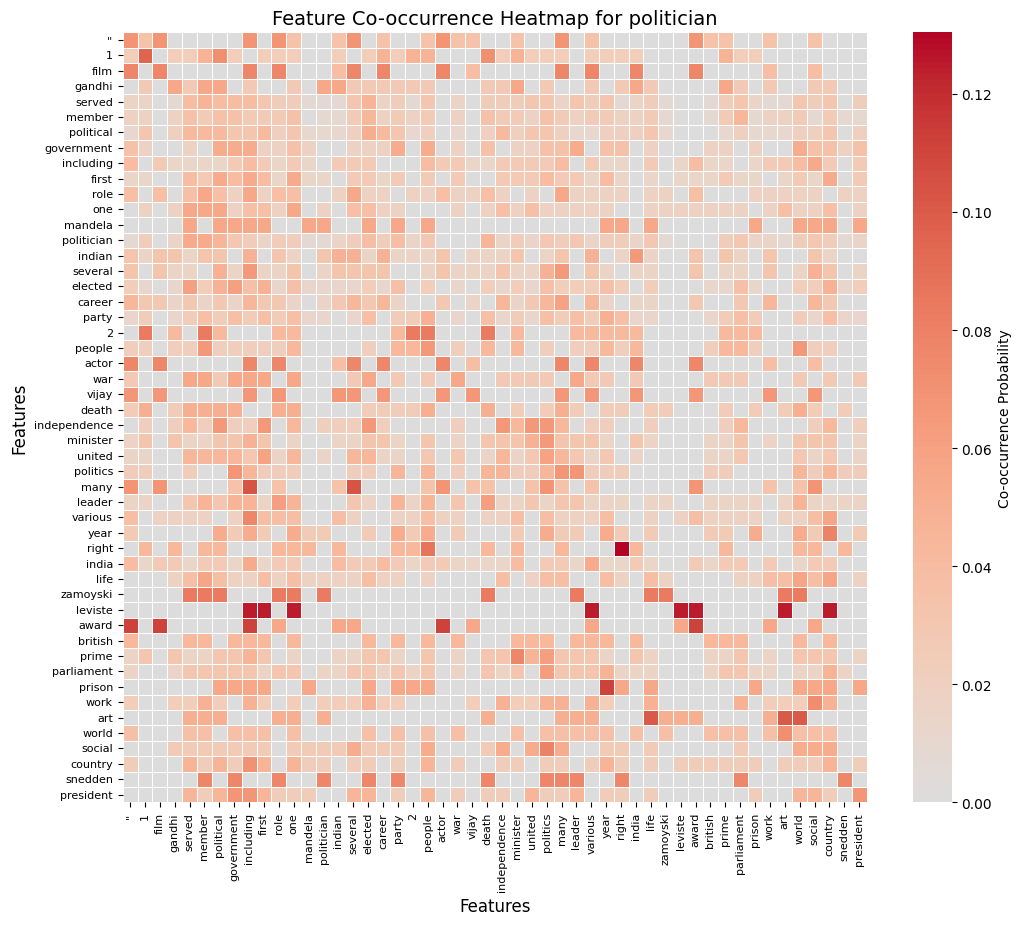

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, occupation):
    # Unpack the data
    features = data['features']
    matrix = data['matrix']

    # Create a heatmap using seaborn
    plt.figure(figsize=(12, 10))  # Increase figure size for better readability
    sns.heatmap(matrix, xticklabels=features, yticklabels=features, 
                cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Co-occurrence Probability'})

    plt.title(f'Feature Co-occurrence Heatmap for {occupation}', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()

# Example usage
occupation = 'politician'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)
